In [226]:
import numpy as np
from datetime import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import dask
dask.config.set(scheduler = "single-threaded")

In [227]:
# Pre-process data
# --------------------------------------

save_path = 'processedData/'

# Doppler LiDAR 
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgpdlprofwind4newsC1.c1.*.nc')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)

    ref_day  = ds['base_time'].values
    ref_year = np.datetime64(datetime(pd.to_datetime(ref_day).year, 1, 1))

    # ds = ds.assign(day_tcyc  = (['time'], ((ds.time - ref_day)  / np.timedelta64(1, 'D')).values))
    # ds = ds.assign(year_tcyc = (['time'], ((ds.time - ref_year) / np.timedelta64(1, 'D')).values))

    # ds['u'] = (('time','height'), (ds['wind_speed'] * np.cos(np.deg2rad(ds['wind_direction']))).values)
    # ds['v'] = (('time','height'), (ds['wind_speed'] * np.sin(np.deg2rad(ds['wind_direction']))).values)

    u_mask = (np.abs(ds['u_error']/ds['u']) <= 1).values.astype(float)
    u_mask[u_mask == 0] = np.nan

    v_mask = (np.abs(ds['v_error']/ds['v']) <= 1).values.astype(float)
    v_mask[v_mask == 0] = np.nan

    mask = u_mask * v_mask

    ds['u'] = (('time', 'height'), ds['u'].values * mask)
    ds['v'] = (('time', 'height'), ds['v'].values * mask)

    ds = ds[['u', 'v']].transpose()

    ds = ds.sel(height = slice(3000))

    ds.to_netcdf(orig_path + save_path + file_name)

# Near-surface anemometer
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgpco2flxwindC1.b1.*.nc')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)

    low_spd = np.zeros((3, ds['time'].shape[0]))
    low_spd[0, :] = ds['wind_speed_4m'].values
    low_spd[1, :] = ds['wind_speed_25m'].values
    low_spd[2, :] = ds['wind_speed_60m'].values 

    low_dir = np.zeros((3, ds['time'].shape[0]))
    low_dir[0, :] = ds['wind_direction_4m'].values
    low_dir[1, :] = ds['wind_direction_25m'].values
    low_dir[2, :] = ds['wind_direction_60m'].values   

    ds_new = xr.Dataset({
    'u': xr.DataArray(
                data   = (-low_spd * np.sin(np.deg2rad(low_dir))),   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': [4, 25, 60], 'time': ds['time']},
    ),
    'v': xr.DataArray(
                data   = (-low_spd * np.cos(np.deg2rad(low_dir))),   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': [4, 25, 60], 'time': ds['time']},
    ),
        })

    ds_new.to_netcdf(orig_path + save_path + file_name)

# High-altitude interpolated sonde
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/interpsondeData/sgpinterpolatedsondeC1.c1.*')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('interpsondeData/')
    ds = xr.load_dataset(file)

    ds = ds.rename({'u_wind' : 'u', 'v_wind' : 'v'})
    
    u_mask = (ds['qc_u_wind'] == 0).values.astype(float)
    u_mask[u_mask == 0] = np.nan

    v_mask = (ds['qc_v_wind'] == 0).values.astype(float)
    v_mask[u_mask == 0] = np.nan

    mask = u_mask * v_mask

    ds['u'] = (('time', 'height'), (ds['u'] * mask).values)
    ds['v'] = (('time', 'height'), (ds['v'] * mask).values)

    ds['height'] = ds['height'] * 1000

    ds = ds[['u', 'v']].transpose()

    ds = ds.sel(height = slice(3000))

    ds.to_netcdf(orig_path + save_path + file_name)

# Met mast
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgpmawsC1.b1.*.nc')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)

    spd_mask = (ds['qc_wind_speed'] == 0).values.astype(float)
    spd_mask[spd_mask == 0] = np.nan

    dir_mask = (ds['qc_wind_direction'] == 0).values.astype(float)
    dir_mask[dir_mask == 0] = np.nan

    mask = spd_mask * dir_mask 

    ds_wind = xr.Dataset({
    'u': xr.DataArray(
                data   = (ds['wind_speed'] * np.sin(np.deg2rad(ds['wind_direction']))).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
    'v': xr.DataArray(
                data   = (ds['wind_speed'] * np.cos(np.deg2rad(ds['wind_direction']))).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
        })

    ds_wind = ds_wind.expand_dims({'height' : [10]})

    ds_wind.to_netcdf(orig_path + save_path + file_name)

# AERI spectra temperature profile
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgpaeriprof3feltzC1.*.cdf')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)
    
    mask_t  = (ds['qc_temperature'] == 0).values.astype(float)
    mask_p  = (ds['qc_pressure'] == 0).values.astype(float)
    mask_mr = (ds['qc_waterVaporMixingRatio'] == 0).values.astype(float)
    mask_t[mask_t == 0] = np.nan
    mask_p[mask_p == 0] = np.nan
    mask_mr[mask_mr == 0] = np.nan

    mask = mask_t * mask_p * mask_mr

    theta = (ds.temperature * (100 / ds.pressure)**(287.05/1004) * (1 + 0.61 * 0.001 * ds.waterVaporMixingRatio)) * mask

    ds['virPoTemp'] = (('time', 'height'), theta.values)

    ds = ds[['virPoTemp']].transpose()

    ds = ds.sel(height = slice(3000))

    ds.to_netcdf(orig_path + save_path + file_name)

# Met mast
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgp1twrmrC1.c1.*')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)

    temp = np.zeros((3, ds['time'].shape[0]))
    temp[0, :] = ds['temp_02m'].values + 273.15
    temp[1, :] = ds['temp_25m'].values + 273.15
    temp[2, :] = ds['temp_60m'].values + 273.15

    mask_2  = (ds['qc_temp_02m'] == 0).values.astype(float)
    mask_25 = (ds['qc_temp_25m'] == 0).values.astype(float)
    mask_60 = (ds['qc_temp_60m'] == 0).values.astype(float)
    mask_2[mask_2 == 0] = np.nan
    mask_25[mask_25 == 0] = np.nan
    mask_60[mask_60 == 0] = np.nan

    mask = mask_2 * mask_25 * mask_60

    ds_new = xr.Dataset({
    'temp': xr.DataArray(
                data   = temp * mask,   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': [2, 25, 60], 'time': ds['time']},
    ),
        })

    ds_new.to_netcdf(orig_path + save_path + file_name)

# CO2 Flux Data
# --------------------------------------------------------------------------------------------

jpgFilenamesList = glob.glob('/Users/smata/Downloads/sampleData/sgpco2flx60mC1.b1.*.nc')
jpgFilenamesList = sorted(jpgFilenamesList)

for file in jpgFilenamesList:
    orig_path, _, file_name = file.partition('sampleData/')
    ds = xr.load_dataset(file)
    
    mask_mf = (ds['qc_momentum_flux'] == 1).values.astype(float)
    mask_hf = (ds['qc_sensible_heat_flux'] == 1).values.astype(float)
    mask_mf[mask_mf == 0] = np.nan
    mask_hf[mask_hf == 0] = np.nan

    mask = mask_mf * mask_hf

    ds_new = xr.Dataset({
    'mom_flux': xr.DataArray(
                data   = (ds['momentum_flux'] * mask).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
    'sh_flux': xr.DataArray(
                data   = (ds['sensible_heat_flux'] * mask).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
    'TKE': xr.DataArray(
                data   = (ds['turbulent_kinetic_energy'] * mask).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
    'L': xr.DataArray(
                data   = (ds['monin_obukov_length'] * mask).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
    'stabilityParameter': xr.DataArray(
                data   = (ds['monin_obukov_stability_parameter'] * mask).values,   # enter data here
                dims   = ['time'],
                coords = {'time': ds['time']},
    ),
        })

    ds_new.to_netcdf(orig_path + save_path + file_name)

In [225]:
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/interpsondeData/sgpinterpolatedsondeC1.c1.*', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgpdlprofwind4newsC1.*', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgpco2flxwindC1.b1.*.nc', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgpmawsC1.b1.*.nc', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgpaeriprof3feltzC1.*.cdf', combine='by_coords', parallel=True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgp1twrmrC1.c1.*', combine='by_coords', parallel=True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/sampleData/sgpco2flx60mC1.b1.*.nc', combine='by_coords', parallel=True)
ds2.sensible_heat_flux

<xarray.DataArray 'sensible_heat_flux' (time: 1488)>
dask.array<concatenate, shape=(1488,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-08-01T00:15:00 ... 2023-08-31T23:45:00
Attributes:
    long_name:            Corrected sensible heat flux
    units:                W/m^2
    ancillary_variables:  qc_sensible_heat_flux
    standard_name:        surface_upward_sensible_heat_flux

In [187]:
theta = ds2.temperature * (100 / ds2.pressure)**(287.05/1004) * (1 + 0.61 * 0.001 * ds2.waterVaporMixingRatio)

[]

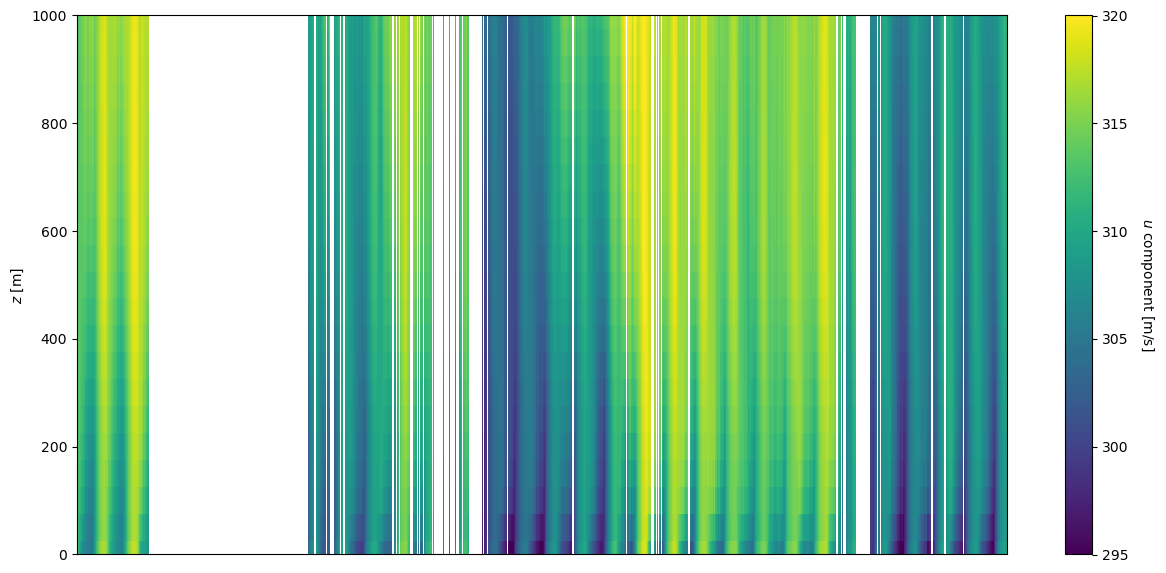

In [200]:
fig,ax = plt.subplots(1, 1, figsize = (15, 7))

cntf = ax.pcolormesh(ds2.time, ds2.height,theta.T, vmin = 295, vmax = 320)
# cntf = ax.pcolormesh(ds2.time, ds2.height,(ds2['temperature']).T, vmin = 295, vmax = 320)

cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = -90, labelpad = 20)
ax.set_ylabel("$z$ [m]")
ax.set_ylim([0, 1000])
ax.get_xaxis().set_ticks([])

(-1.0, 10.0)

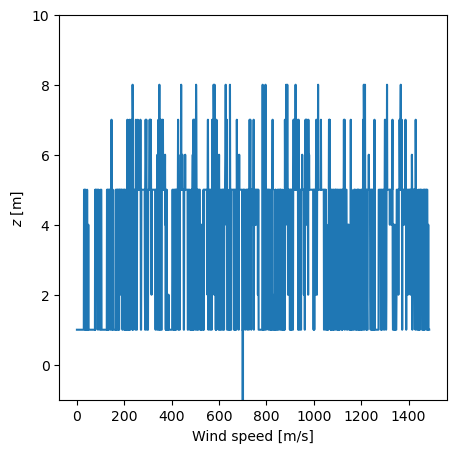

In [215]:
fig,ax = plt.subplots(figsize = (5, 5))

ax.plot(range(len(ds2.qc_momentum_flux.values)), ds2.qc_momentum_flux.values)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('$z$ [m]')
ax.set_ylim([-1, 10])
# ax.set_xlim([295, 315])

In [106]:
ds = ds2

spd_mask = (ds['qc_wind_speed'] == 0).values.astype(float)
spd_mask[spd_mask == 0] = np.nan

dir_mask = (ds['qc_wind_direction'] == 0).values.astype(float)
dir_mask[dir_mask == 0] = np.nan

mask = spd_mask * dir_mask 

ds_wind = xr.Dataset({
'u': xr.DataArray(
            data   = (ds['wind_speed'] * np.sin(np.deg2rad(ds['wind_direction']))).values,   # enter data here
            dims   = ['time'],
            coords = {'time': ds['time']},
),
'v': xr.DataArray(
            data   = (ds['wind_speed'] * np.cos(np.deg2rad(ds['wind_direction']))).values,   # enter data here
            dims   = ['time'],
            coords = {'time': ds['time']},
),
    })

ds_wind = ds_wind.expand_dims({'height' : [4]})

ds_wind

<xarray.Dataset>
Dimensions:  (height: 1, time: 12960)
Coordinates:
  * height   (height) int64 4
  * time     (time) datetime64[ns] 2023-08-01T00:00:05 ... 2023-08-09T23:59:06
Data variables:
    u        (height, time) float32 3.55 4.239 4.225 ... -1.258 -1.035 -1.08
    v        (height, time) float32 -6.149 -6.784 -7.947 ... 5.046 3.864 4.677